<a href="https://colab.research.google.com/github/escuccim/pytorch-face-autoencoder/blob/master/eas7_faces_gan_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training the gan and the autoencoder doesn't seem to be working, so we'll just try to train a GAN to make sure everything is correct before we start trying to train them together.

In [0]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
%matplotlib inline
import zipfile
import os
import matplotlib.animation as animation
import torchvision.utils as vutils

from google.colab import auth
auth.authenticate_user()

# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}

In [0]:
# !gsutil cp gs://{bucket_name}/model_30_trained.pt ./gen_model_1g.pt
!gsutil cp gs://{bucket_name}/gen_model_1g1.pt ./gen_model_1g.pt
!gsutil cp gs://{bucket_name}/disc_model_1g1.pt ./disc_model_1g.pt

# !gsutil cp gs://{bucket_name}/gen_model_31.pt ./gen_model_1g.pt
# !gsutil cp gs://{bucket_name}/disc_model_31.pt ./disc_model_1g.pt

Copying gs://pneumonia/gen_model_1g1.pt...
- [1 files][ 36.5 MiB/ 36.5 MiB]                                                
Operation completed over 1 objects/36.5 MiB.                                     
Copying gs://pneumonia/disc_model_1g1.pt...
- [1 files][ 44.6 MiB/ 44.6 MiB]                                                
Operation completed over 1 objects/44.6 MiB.                                     


In [0]:
# if not os.path.exists("celeba-dataset.zip"):
# #   !kaggle datasets download -d jessicali9530/celeba-dataset
#   !gsutil cp gs://{bucket_name}/celeba-dataset.zip ./celeba-dataset.zip
#   zip_ref = zipfile.ZipFile('celeba-dataset.zip', 'r')
#   zip_ref.extractall('data')
#   zip_ref.close()

#   zip_ref = zipfile.ZipFile('data/img_align_celeba.zip', 'r')
#   zip_ref.extractall('data/images')
#   zip_ref.close()
  
# if not os.path.exists("Training_Pictures.zip"):
#   !wget https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/Training_Pictures.zip
#   zip_ref = zipfile.ZipFile('Training_Pictures.zip', 'r')
#   zip_ref.extractall('data/images')
#   zip_ref.close()  

# if not os.path.exists("imdb_images3.zip"):
#   !gsutil cp gs://{bucket_name}/imdb_images3.zip ./imdb_images3.zip
#   zip_ref = zipfile.ZipFile('imdb_images3.zip', 'r')
#   zip_ref.extractall('data/images')
#   zip_ref.close()

# if not os.path.exists("GWB_200x200_JPEG.zip"):
#   !wget https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/GWB_200x200_JPEG.zip
#   zip_ref = zipfile.ZipFile('GWB_200x200_JPEG.zip', 'r')
#   zip_ref.extractall('data/images')               
#   zip_ref.close()  

In [0]:
if not os.path.exists("celeb_a_good.zip"):
#   !kaggle datasets download -d jessicali9530/celeba-dataset
  !gsutil cp gs://{bucket_name}/celeb_a_good.zip ./celeb_a_good.zip
  zip_ref = zipfile.ZipFile('celeb_a_good.zip', 'r')
  zip_ref.extractall('data/images/celeb_a')
  zip_ref.close()

if not os.path.exists("Training_Pictures.zip"):
  !wget https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/Training_Pictures.zip
  zip_ref = zipfile.ZipFile('Training_Pictures.zip', 'r')
  zip_ref.extractall('data/images/training')
  zip_ref.close()
  
# if not os.path.exists("imdb_crop_good.zip"):  
#   !gsutil cp gs://{bucket_name}/imdb_crop_good.zip ./imdb_crop_good.zip
#   zip_ref = zipfile.ZipFile('imdb_crop_good.zip', 'r')
#   zip_ref.extractall('data/images/imdb')
#   zip_ref.close()

# if not os.path.exists("crop_part1_good.zip"):
#   !gsutil cp gs://{bucket_name}/crop_part1_good.zip ./crop_part1_good.zip
#   zip_ref = zipfile.ZipFile('crop_part1_good.zip', 'r')
#   zip_ref.extractall('data/images/crop_parta')
#   zip_ref.close()   

Copying gs://pneumonia/celeb_a_good.zip...
/ [1 files][  1.1 GiB/  1.1 GiB]   77.9 MiB/s                                   
Operation completed over 1 objects/1.1 GiB.                                      
--2019-09-04 05:43:25--  https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/Training_Pictures.zip
Resolving s3.eu-west-3.amazonaws.com (s3.eu-west-3.amazonaws.com)... 52.95.154.49
Connecting to s3.eu-west-3.amazonaws.com (s3.eu-west-3.amazonaws.com)|52.95.154.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 955202 (933K) [application/zip]
Saving to: ‘Training_Pictures.zip’

Training_Pictures.z 100%[===================>] 932.81K  1.98MB/s    in 0.5s    

2019-09-04 05:43:26 (1.98 MB/s) - ‘Training_Pictures.zip’ saved [955202/955202]



In [0]:
# get test data
if not os.path.exists("imdb_crop_test.zip"):
  !gsutil cp gs://{bucket_name}/imdb_crop_test.zip ./imdb_crop_test.zip
  zip_ref = zipfile.ZipFile('imdb_crop_test.zip', 'r')
  zip_ref.extractall('data/test_images')
  zip_ref.close()
  
# if not os.path.exists("wiki_images_good.zip"):
#   !gsutil cp gs://{bucket_name}/wiki_images_good.zip ./wiki_images_good.zip
#   zip_ref = zipfile.ZipFile('wiki_images_good.zip', 'r')
#   zip_ref.extractall('data/test_images')
#   zip_ref.close()  

# if not os.path.exists("faces94.zip"):
#   !wget https://cswww.essex.ac.uk/mv/allfaces/faces94.zip
#   zip_ref = zipfile.ZipFile('faces94.zip', 'r')
#   zip_ref.extractall('data/test_images')
#   zip_ref.close()
  
# # if not os.path.exists("faces96.zip"):
# #   !wget https://cswww.essex.ac.uk/mv/allfaces/faces96.zip  
# #   zip_ref = zipfile.ZipFile('faces96.zip', 'r')
# #   zip_ref.extractall('data/test_images')
# #   zip_ref.close()

# if not os.path.exists("faces95.zip"):
#   !wget https://cswww.essex.ac.uk/mv/allfaces/faces95.zip  
#   zip_ref = zipfile.ZipFile('faces95.zip', 'r')
#   zip_ref.extractall('data/test_images')
#   zip_ref.close()

# # if not os.path.exists("GWB_200x200_JPEG.zip"):
# #   !wget https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/GWB_200x200_JPEG.zip
# #   zip_ref = zipfile.ZipFile('GWB_200x200_JPEG.zip', 'r')
# #   zip_ref.extractall('data/test_images')
# #   zip_ref.close()  
  
# if not os.path.exists("celeb_a_test.zip"):
#   !gsutil cp gs://{bucket_name}/celeb_a_test.zip ./celeb_a_test.zip
#   zip_ref = zipfile.ZipFile('celeb_a_test.zip', 'r')
#   zip_ref.extractall('data/test_images')
#   zip_ref.close()       
  
# if not os.path.exists("wiki_crop_test.zip"):
#   !gsutil cp gs://{bucket_name}/wiki_crop_test.zip ./wiki_crop_test.zip
#   zip_ref = zipfile.ZipFile('wiki_crop_test.zip', 'r')
#   zip_ref.extractall('data/test_images')
#   zip_ref.close()     
  

# if not os.path.exists("crop_part1_test.zip"):
#   !gsutil cp gs://{bucket_name}/crop_part1_test.zip ./crop_part1_test.zip
#   zip_ref = zipfile.ZipFile('crop_part1_test.zip', 'r')
#   zip_ref.extractall('data/test_images')
#   zip_ref.close()     

Copying gs://pneumonia/imdb_crop_test.zip...
- [1 files][216.8 MiB/216.8 MiB]                                                
Operation completed over 1 objects/216.8 MiB.                                    


In [0]:
# Root directory for dataset
dataroot = "data/images"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 160

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 512

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [0]:
BATCH_SIZE = batch_size
data_path = "data/images"

transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(p=0.5), 
      torchvision.transforms.RandomApply([
        torchvision.transforms.RandomAffine(degrees=5, translate=(0.075,0.075), scale=(0.9,1.15), shear=4, resample=False, fillcolor=0),        
      ], 0.7),
      torchvision.transforms.RandomResizedCrop((image_size,image_size), scale=(0.8, 1.20)),
      torchvision.transforms.ToTensor(),
    ])

transform2 = torchvision.transforms.Compose(
    [torchvision.transforms.RandomResizedCrop((image_size,image_size), scale=(0.95, 1.05)),
      torchvision.transforms.ToTensor(),
    ])

train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transform
    )

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
    shuffle=True
)

test_dataset = torchvision.datasets.ImageFolder(
        root="data/test_images",
        transform=transform2
    )

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=48,
    num_workers=1,
    shuffle=True
)

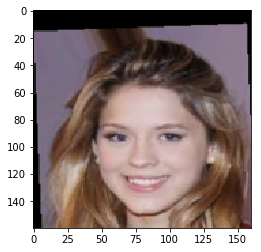

In [0]:
for (images, _) in train_loader:
  plt.imshow(images[0].permute(1,2,0))
  plt.show()
  break

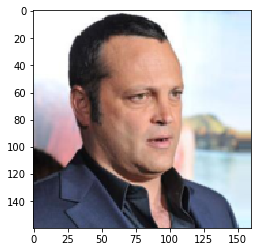

In [0]:
for (images, _) in test_loader:
  plt.imshow(images[0].permute(1,2,0))
  plt.show()
  break

In [0]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 166889
    Root location: data/images

In [0]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 21348
    Root location: data/test_images

In [0]:
def output_size(i, k=3, p=2, s=1, d=1):
    o = (i + 2*p - k - (k-1)*(d-1))/s + 1
    return o
  
output_size(i=64, k=3, p=1)

64.0

### Create Models

In [0]:
epoch_list = []

In [0]:
criterion = torch.nn.BCELoss()
real_label = 0.10
fake_label = 1.
latent_dim = 512

fixed_noise = torch.randn(16, latent_dim, 1, 1).cuda()
criterion = torch.nn.BCELoss()

def vae_loss(x, x_hat, d_faked=None, debug=False):
    beta_mse = 15.0
    beta_kld = 0.1
    beta_gloss = 1.0
    
    # MSE for reconstructions
    MSE = nn.functional.mse_loss(x, x_hat)
    MSE *= beta_mse
    
    # weight the MSE loss higher so the discriminator loss doesn't overwhelm it
    if d_faked is not None:
        ones = torch.ones(d_faked.shape[0]).cuda()
        g_loss =  nn.functional.binary_cross_entropy_with_logits(d_faked, ones, reduction="mean")
        g_loss *= beta_gloss
    else:
        g_loss = torch.zeros(1).cuda()
        
    # print out loss info if we want to debug
    if debug:
        print("MSE Loss Raw:", MSE)
        print("MSE Loss Weighted:", MSE * beta_mse)
        print("KLD Loss Raw:", KLD)
        print("KLD Loss Weighted:", KLD * beta_kld)
        if d_faked is not None:
            print("Disc Loss Raw:", g_loss)
            print("Disc Loss Weighted:", g_loss * beta_gloss)
        print("Total Loss (weighted):", total_loss)
    
    return MSE + g_loss, MSE, 0, g_loss
  
def disc_loss(labels, logits):
    s_logits = torch.sigmoid(logits)    
    d_loss = criterion(s_logits, labels)
    return d_loss

def disc_loss2(labels, logits):
    d_loss = nn.functional.binary_cross_entropy_with_logits(logits, labels, reduction="mean")
    
    return d_loss    

  
def train_gan(discriminator, generator, train_loader, d_optimizer, g_optimizer, extra_gen_train=8, test_loader=None, print_metrics=1000, plot_images=4000,
              separate_batches=True, num_epochs=10, g_scheduler=None, d_scheduler=None, d_save_path="disc_model_1g.pt",
              g_save_path="gen_model_1g.pt"):
    try:
        for epoch in range(num_epochs):
            discriminator.train()
            generator.train()

            d_upload_path = d_save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt"
            g_upload_path = g_save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt"

            mse_losses = [0.5]
            kld_losses = [0.5]
            g_tr_losses = [0.5]
            d_tr_losses = [0.5]

            d_test_loss = 0.0
            g_test_loss = 0.0
            test_losses = [0.5]
            test_d_losses = [0.5]
            
            real_accs = [0.5]
            fake_accs = [0.5]
            batch_accuracies = [0.5]
            
            test_d_acc = [0.5]
            
            batch_losses = [0.5]
            disc_losses = [0.5]

            for i, (inputs, _) in enumerate(train_loader):
                # if the batch is too small skip so we don't have problems with batch norm
                if inputs.shape[0] <= 2:
                    continue

                if use_cuda and torch.cuda.is_available():
                    inputs = inputs.cuda()
                 
                batch_size = inputs.shape[0]
                
                ## Train discriminator
                d_optimizer.zero_grad()

                # make labels for the batch
                if use_cuda and torch.cuda.is_available():
                    real_labels = torch.full((batch_size,), real_label).cuda()
                    fake_labels = torch.full((batch_size,), fake_label).cuda()
                else:
                    real_labels = torch.full((batch_size,), real_label)
                    fake_labels = torch.full((batch_size,), fake_label)
                
                # create a fake batch
                noise = torch.randn(batch_size, latent_dim, 1, 1).cuda()
                recon = generator(noise)
                    
                # do we need to train the discriminator on this batch?
                if extra_gen_train < 0 or i % extra_gen_train == 0:
                    # train with real batch
                    output = discriminator(inputs)
                    d_loss_real = disc_loss(real_labels, output)
                    d_loss_real.backward()
                    
                    # get accuracy for real batch
                    r_probs = torch.sigmoid(output)
                    r_acc = torch.mean((torch.round(r_probs) == torch.round(real_labels)).double())
                    real_accs.append(r_probs.mean().item())
                    
                    # train with fake batch
                    output = discriminator(recon.detach())
                    d_loss_fake = disc_loss(fake_labels, output)
                    d_loss_fake.backward()

                    # calculate the accuracy for the fake batch
                    f_probs = torch.sigmoid(output)
                    f_acc = torch.mean((torch.round(f_probs) == torch.round(fake_labels)).double())
                    fake_accs.append(f_probs.mean().item())
                    
                    d_accuracy = np.mean([f_acc.item(), r_acc.item()])
                    
                    # append the metrics
                    batch_accuracies.append(d_accuracy)

                    # add the losses
                    d_loss = d_loss_fake + d_loss_real
                    # step the optimizer
                    d_optimizer.step()

                    d_tr_losses.append(d_loss.item())

                ## Train generator
                g_optimizer.zero_grad()
                
                # pass another all fake batch through disc
                output = discriminator(recon)
                g_loss = disc_loss(torch.round(real_labels), output)
                
                g_loss.backward()
                g_optimizer.step()
        
                # calculate some metrics
                g_tr_losses.append(g_loss.item())

                if i > 0 and print_metrics != 0 and i % print_metrics == 0:
                    print("\tEpoch", len(epoch_list), "batch", i, "gen total loss:",
                          np.mean(g_tr_losses[-print_metrics:]), "disc loss:", np.mean(d_tr_losses[-print_metrics:]), "real probs:", np.mean(real_accs[-print_metrics:]),
                          "fake probs:", np.mean(fake_accs[-print_metrics:]),
                          "disc acc:", np.mean(batch_accuracies[-print_metrics:]))

                if i % plot_images == 0 and i > 0:
                    fig, ax = plt.subplots(1, 2, figsize=(6, 6))
                    ax[0].imshow(recon[1].cpu().detach().permute(1, 2, 0))
                    ax[1].imshow(recon[0].cpu().detach().permute(1, 2, 0))
                    plt.show()

            # plot a few random images
            try:
                fig, ax = plt.subplots(2, 2, figsize=(6, 6))
                fig.suptitle("Training Images")
                ax[0, 0].imshow(inputs[0].cpu().permute(1, 2, 0))
                ax[0, 1].imshow(recon[0].cpu().detach().permute(1, 2, 0))
                ax[1, 0].imshow(inputs[1].cpu().permute(1, 2, 0))
                ax[1, 1].imshow(recon[1].cpu().detach().permute(1, 2, 0))
                plt.show()
            except Exception as e:
                print(e)

            torch.save(discriminator.state_dict(), d_save_path)
            torch.save(generator.state_dict(), g_save_path)

            if test_loader is not None:
                generator.eval()
                discriminator.eval()
                with torch.no_grad():
                    for i, (inputs, _) in enumerate(test_loader):
                        if use_cuda and torch.cuda.is_available():
                            inputs = inputs.cuda()

                        # autoencode the input images
                        recon, code, logvar = generator(inputs)

                        loss, _, _, _ = vae_loss(inputs, recon)
                        test_losses.append(loss.item())

                        # combine the real and recon images into a single batch for the discriminator
                        disc_batch = torch.cat((inputs, recon), 0)

                        # feed the batch to the discriminator
                        d_logits = discriminator(disc_batch)

                        # create labels for the disc loss function
                        batch_size = d_logits.shape[0] // 2
                        if use_cuda and torch.cuda.is_available():
                          real_labels = torch.round(torch.full((batch_size,), real_label).cuda())
                          fake_labels = torch.round(torch.full((batch_size,), fake_label).cuda())
                        else:
                          real_labels = torch.round(torch.full((batch_size,), real_label))
                          fake_labels = torch.round(torch.full((batch_size,), fake_label))

                        labels = torch.cat((real_labels, fake_labels))

                        # run the discriminator loss function
                        d_loss = disc_loss2(labels, d_logits)
                        test_d_losses.append(d_loss.item())

                        # calculate the accuracy of our discriminator
                        d_preds = torch.sigmoid(d_logits).round()
                        d_accuracy = torch.mean((d_preds == labels).double())
                        test_d_acc.append(d_accuracy.item())

                try:
                    fig, ax = plt.subplots(2, 2, figsize=(6, 6))
                    fig.suptitle("Test Images")
                    ax[0, 0].imshow(inputs[0].cpu().permute(1, 2, 0))
                    ax[0, 1].imshow(recon[0].cpu().detach().permute(1, 2, 0))
                    ax[1, 0].imshow(inputs[1].cpu().permute(1, 2, 0))
                    ax[1, 1].imshow(recon[1].cpu().detach().permute(1, 2, 0))
                    plt.show()
                except Exception as e:
                    print(e)

            print("Epoch:", len(epoch_list), "Gen Train Loss:", np.mean(g_tr_losses), "MSE Loss:", np.mean(mse_losses),
                  "KLD Loss:", np.mean(kld_losses), "Mean GAN XE Loss:", np.mean(disc_losses), "Disc Train Loss:",
                  np.mean(d_tr_losses), "Test Loss:", np.mean(test_losses), "Real probs:", np.mean(real_accs),  
                  "Fake probs:", np.mean(fake_accs), "Avg Te Disc Acc:", np.mean(test_d_acc))

            epoch_list.append(epoch)

            if g_scheduler is not None and epoch % 5 == 0 and epoch > 1:
                g_scheduler.step()

            if d_scheduler is not None and epoch % 5 == 0 and epoch > 1:
                d_scheduler.step()

    except KeyboardInterrupt:
        print("Epoch:", len(epoch_list), "Gen Train Loss:", np.mean(g_tr_losses), "MSE Loss:", np.mean(mse_losses),
              "Mean GAN XE Loss:", np.mean(disc_losses), "Disc Train Loss:", np.mean(d_tr_losses), "Avg Tr Disc Acc:",
              np.mean(batch_accuracies))
        print("Interrupting... Saving model...")
        torch.save(generator.state_dict(), g_save_path)
        torch.save(discriminator.state_dict(), d_save_path)
        !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
        !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}
        return
#     except Exception as e:
#         print("Value error... Saving model...")
#         print(e)
#         torch.save(generator.state_dict(), g_save_path)
#         torch.save(discriminator.state_dict(), d_save_path)
#         !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
#         !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}
#         return

    !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
    !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}

# single batch for disc instead of separate batches      
def train_gan3(discriminator, generator, train_loader, d_optimizer, g_optimizer, extra_gen_train=8, test_loader=None, print_metrics=1000, plot_images=4000,
              separate_batches=True, num_epochs=10, g_scheduler=None, d_scheduler=None, d_save_path="disc_model_1g.pt",
              g_save_path="gen_model_1g.pt"):
    try:
        for epoch in range(num_epochs):
            discriminator.train()
            generator.train()

            d_upload_path = d_save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt"
            g_upload_path = g_save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt"

            mse_losses = [0.5]
            kld_losses = [0.5]
            g_tr_losses = [0.5]
            d_tr_losses = [0.5]

            d_test_loss = 0.0
            g_test_loss = 0.0
            test_losses = [0.5]
            test_d_losses = [0.5]
            
            real_accs = [0.5]
            fake_accs = [0.5]
            batch_accuracies = [0.5]
            
            test_d_acc = [0.5]
            
            batch_losses = []
            disc_losses = []

            for i, (inputs, _) in enumerate(train_loader):
                # if the batch is too small skip so we don't have problems with batch norm
                if inputs.shape[0] <= 2:
                    continue

                if use_cuda and torch.cuda.is_available():
                    inputs = inputs.cuda()
                 
                batch_size = inputs.shape[0]
                
                ## Train discriminator
                d_optimizer.zero_grad()

                # make labels for the batch
                if use_cuda and torch.cuda.is_available():
                    real_labels = torch.full((batch_size,), real_label).cuda()
                    fake_labels = torch.full((batch_size,), fake_label).cuda()
                else:
                    real_labels = torch.full((batch_size,), real_label)
                    fake_labels = torch.full((batch_size,), fake_label)
                
                # create a fake batch
                noise = torch.randn(batch_size, latent_dim, 1, 1).cuda()
                recon = generator(noise)
                    
                # do we need to train the discriminator on this batch?
                if extra_gen_train < 0 or i % extra_gen_train == 0:
                    # concat the real and fake together
                    disc_batch = torch.cat((inputs, recon.detach()), 0)
                    disc_labels = torch.cat((real_labels, fake_labels), 0)
                    
                    # run them through the discriminator
                    output = discriminator(disc_batch)
                    # get the probability
                    d_probs = torch.sigmoid(output)
                    
                    # get the loss
                    d_loss = disc_loss(disc_labels, output)
                    d_loss.backward()
                    d_accuracy = torch.mean((torch.round(d_probs) == torch.round(disc_labels)).double())
                    
                    # separate the probs
                    r_probs = d_probs[:batch_size]
                    f_probs = d_probs[batch_size:]
                    
                    # save metrics
                    real_accs.append(r_probs.mean().item())
                    fake_accs.append(f_probs.mean().item())
                    
                    # append the metrics
                    batch_accuracies.append(d_accuracy.item())
                    d_tr_losses.append(d_loss.item())
                    
                    # step the optimizer
                    d_optimizer.step()

                ## Train generator
                g_optimizer.zero_grad()
                
                # pass another all fake batch through disc
                output = discriminator(recon)
                g_loss = disc_loss(real_labels, output)
                
                g_loss.backward()
                g_optimizer.step()
        
                # calculate some metrics
                g_tr_losses.append(g_loss.item())
#                 mse_losses.append(mse.item())
#                 disc_losses.append(disc_loss.item())

                if i > 0 and print_metrics != 0 and i % print_metrics == 0:
                    print("\tEpoch", len(epoch_list), "batch", i, "gen total loss:",
                          np.mean(g_tr_losses[-print_metrics:]), "disc loss:", np.mean(d_tr_losses[-print_metrics:]), "real probs:", np.mean(real_accs[-print_metrics:]),
                          "fake probs:", np.mean(fake_accs[-print_metrics:]),
                          "disc acc:", np.mean(batch_accuracies[-print_metrics:]))

                if i % plot_images == 0 and i > 0:
                    fig, ax = plt.subplots(1, 2, figsize=(6, 6))
                    ax[0].imshow(recon[0].cpu().detach().permute(1, 2, 0))
                    ax[1].imshow(recon[1].cpu().detach().permute(1, 2, 0))
                    plt.show()

            # plot a few random images
            try:
                fig, ax = plt.subplots(2, 2, figsize=(6, 6))
                fig.suptitle("Training Images")
                ax[0, 0].imshow(inputs[0].cpu().permute(1, 2, 0))
                ax[0, 1].imshow(recon[0].cpu().detach().permute(1, 2, 0))
                ax[1, 0].imshow(inputs[1].cpu().permute(1, 2, 0))
                ax[1, 1].imshow(recon[1].cpu().detach().permute(1, 2, 0))
                plt.show()
            except Exception as e:
                print(e)

            torch.save(discriminator.state_dict(), d_save_path)
            torch.save(generator.state_dict(), g_save_path)

            if test_loader is not None:
                generator.eval()
                discriminator.eval()
                with torch.no_grad():
                    for i, (inputs, _) in enumerate(test_loader):
                        if use_cuda and torch.cuda.is_available():
                            inputs = inputs.cuda()

                        # autoencode the input images
                        recon, code, logvar = generator(inputs)

                        loss, _, _, _ = vae_loss(inputs, recon)
                        test_losses.append(loss.item())

                        # combine the real and recon images into a single batch for the discriminator
                        disc_batch = torch.cat((inputs, recon), 0)

                        # feed the batch to the discriminator
                        d_logits = discriminator(disc_batch)

                        # create labels for the disc loss function
                        if use_cuda and torch.cuda.is_available():
                            real_labels = torch.full((batch_size,), real_label).cuda()
                            fake_labels = torch.full((batch_size,), fake_label).cuda()
                        else:
                            real_labels = torch.full((batch_size,), real_label)
                            fake_labels = torch.full((batch_size,), fake_label)

                        labels = torch.cat((real_labels, fake_labels))

                        # run the discriminator loss function
                        d_loss = disc_loss2(labels, d_logits)
                        test_d_losses.append(d_loss.item())

                        # calculate the accuracy of our discriminator
                        d_preds = torch.sigmoid(d_logits).round()
                        d_accuracy = torch.mean((d_preds == torch.round(labels)).double())
                        test_d_acc.append(d_accuracy.item())

                try:
                    fig, ax = plt.subplots(2, 2, figsize=(6, 6))
                    fig.suptitle("Test Images")
                    ax[0, 0].imshow(inputs[0].cpu().permute(1, 2, 0))
                    ax[0, 1].imshow(recon[0].cpu().detach().permute(1, 2, 0))
                    ax[1, 0].imshow(inputs[1].cpu().permute(1, 2, 0))
                    ax[1, 1].imshow(recon[1].cpu().detach().permute(1, 2, 0))
                    plt.show()
                except Exception as e:
                    print(e)

            print("Epoch:", len(epoch_list), "Gen Train Loss:", np.mean(g_tr_losses), "MSE Loss:", np.mean(mse_losses),
                  "KLD Loss:", np.mean(kld_losses), "Mean GAN XE Loss:", np.mean(disc_losses), "Disc Train Loss:",
                  np.mean(d_tr_losses), "Test Loss:", np.mean(test_losses), "Real probs:", np.mean(real_accs),  
                  "Fake probs:", np.mean(fake_accs), "Avg Te Disc Acc:", np.mean(test_d_acc))

            epoch_list.append(epoch)

            if g_scheduler is not None and epoch % 5 == 0 and epoch > 1:
                g_scheduler.step()

            if d_scheduler is not None and epoch % 5 == 0 and epoch > 1:
                d_scheduler.step()

    except KeyboardInterrupt:
        print("Epoch:", len(epoch_list), "Gen Train Loss:", np.mean(g_tr_losses), "MSE Loss:", np.mean(mse_losses),
              "Mean GAN XE Loss:", np.mean(disc_losses), "Disc Train Loss:", np.mean(d_tr_losses), "Avg Tr Disc Acc:",
              np.mean(batch_accuracies))
        print("Interrupting... Saving model...")
        torch.save(generator.state_dict(), g_save_path)
        torch.save(discriminator.state_dict(), d_save_path)
        !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
        !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}
        return
#     except Exception as e:
#         print("Value error... Saving model...")
#         print(e)
#         torch.save(generator.state_dict(), g_save_path)
#         torch.save(discriminator.state_dict(), d_save_path)
#         !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
#         !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}
#         return

    !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
    !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}
      

def train_gan2(netD, netG, train_loader, optimizerD, optimizerG, num_epochs=1,  d_save_path="disc_model_1g.pt", g_save_path="gen_model_1g.pt"):
#   (discriminator, generator, train_loader, d_optimizer, g_optimizer, extra_gen_train=8, test_loader=None, print_metrics=1000, plot_images=4000,
#               separate_batches=True, num_epochs=10, g_scheduler=None, d_scheduler=None, d_save_path="disc_model_1g.pt",
#               g_save_path="gen_model_1g.pt"):
    # Lists to keep track of progress
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0

    print("Starting Training Loop...")

    try:
        # For each epoch
        for epoch in range(num_epochs):
            d_upload_path = d_save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt"
            g_upload_path = g_save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt"
            
            epoch_list.append(epoch)
            
            # For each batch in the dataloader
            for i, data in enumerate(train_loader, 0):

                ############################
                # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
                ###########################
                ## Train with all-real batch
                optimizerD.zero_grad()
                # Format batch
                real_cpu = data[0].cuda()
                b_size = real_cpu.size(0)
                label = torch.full((b_size,), real_label).cuda()
                # Forward pass real batch through D
                output = torch.sigmoid(netD(real_cpu).view(-1))
                # Calculate loss on all-real batch
                errD_real = criterion(output, label)
                # Calculate gradients for D in backward pass
                errD_real.backward()
                D_x = output.mean().item()

                ## Train with all-fake batch
                # Generate batch of latent vectors
                noise = torch.randn(b_size, latent_dim, 1, 1).cuda()
                # Generate fake image batch with G
                fake = netG(noise)
                label.fill_(fake_label)
                # Classify all fake batch with D
                output = torch.sigmoid(netD(fake.detach()).view(-1))
                # Calculate D's loss on the all-fake batch
                errD_fake = criterion(output, label)
                # Calculate the gradients for this batch
                errD_fake.backward()
                D_G_z1 = output.mean().item()
                # Add the gradients from the all-real and all-fake batches
                errD = errD_real + errD_fake
                # Update D
                optimizerD.step()

                ############################
                # (2) Update G network: maximize log(D(G(z)))
                ###########################
                optimizerG.zero_grad()
                label.fill_(real_label)  # fake labels are real for generator cost
                # Since we just updated D, perform another forward pass of all-fake batch through D
                output = torch.sigmoid(netD(fake).view(-1))
                # Calculate G's loss based on this output
                errG = criterion(output, label)
                # Calculate gradients for G
                errG.backward()
                D_G_z2 = output.mean().item()
                # Update G
                optimizerG.step()

                # Output training stats
                if i % 250 == 0:
                    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                          % (epoch, num_epochs, i, len(train_loader),
                             errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

                # Save Losses for plotting later
                G_losses.append(errG.item())
                D_losses.append(errD.item())

                # Check how the generator is doing by saving G's output on fixed_noise
                if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
                    with torch.no_grad():
                        fake = netG(fixed_noise).detach().cpu()
                        plt.imshow(fake[0].permute(1, 2, 0))
                        plt.show()
#                     img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

                iters += 1
        
        torch.save(netG.state_dict(), g_save_path)
        torch.save(netD.state_dict(), d_save_path)    
  
    except KeyboardInterrupt:
        print("Interrupting... Saving model...")
        torch.save(netG.state_dict(), g_save_path)
        torch.save(netD.state_dict(), d_save_path)
        !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
        !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}
        return
    
    torch.save(netG.state_dict(), g_save_path)
    torch.save(netD.state_dict(), d_save_path)
    !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
    !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}
      
      
    return
    
def train(model, train_loader, optimizer, test_loader=None, print_metrics=1000, plot_images=4000, num_epochs=10, display_images=5, scheduler=None, save_path="model_6.pt"):
    try:
      for epoch in range(num_epochs):
          model.train()
          upload_path = save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt" 
          
          tr_losses = []
          test_losses = []
          for i, (inputs, _) in enumerate(train_loader):
              if use_cuda and torch.cuda.is_available():
                  inputs = inputs.cuda()

              optimizer.zero_grad()

              recon, code, logvar = model(inputs)
              if model.variational:
                  loss, _, _, _ = vae_loss(inputs, recon)
              else:  
                  loss, _, _, _ = vae_loss(inputs, recon)

              loss.backward()
              optimizer.step()

              tr_losses.append(loss.item())
            
              if i > 0 and print_metrics != 0 and i % print_metrics == 0:
                print("\tEpoch", len(epoch_list), "batch", i, "loss:", np.mean(tr_losses[-print_metrics:]))

              if i % plot_images == 0 and i > 0:
                fig, ax = plt.subplots(1, 2, figsize=(6,6))
                ax[0].imshow(recon[1].cpu().permute(1, 2, 0) )
                ax[1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                plt.show()
          
          if epoch % display_images == 0:
              # plot a few random images
              try:
                fig, ax = plt.subplots(2, 2, figsize=(6,6))
                fig.suptitle("Training Images")
                ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
                ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
                plt.show()
              except Exception as e:
                  print(e)

              torch.save(model.state_dict(), save_path)
#               !gsutil cp ./model.pt gs://{bucket_name}/
          
          if test_loader is not None:
            model.eval()
            with torch.no_grad():
              for i, (inputs, _) in enumerate(test_loader):
                if use_cuda and torch.cuda.is_available():
                    inputs = inputs.cuda()

                recon, code, logvar = model(inputs)

                if model.variational:
                    loss, _, _, _ = vae_loss(inputs, recon)
                else:  
                    loss, _, _, _ = vae_loss(inputs, recon)

                test_losses.append(loss.item())

            try:
                fig, ax = plt.subplots(2, 2, figsize=(6,6))
                fig.suptitle("Test Images")
                ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
                ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
                plt.show()
            except Exception as e:
                print(e)
                  
          print("Epoch:", len(epoch_list), "Train Loss:", np.mean(tr_losses), "Test Loss:", np.mean(test_losses))
          
          epoch_list.append(epoch)
          
          if scheduler is not None and epoch % 5 == 0 and epoch > 1:
              scheduler.step()

                
    except KeyboardInterrupt:
      print("Interrupting... Saving model...")
      torch.save(model.state_dict(), save_path)
      !gsutil cp {save_path} gs://{bucket_name}/{upload_path}
      return 
    except Exception as e:
      print("Error... Saving model...", e)
      torch.save(model.state_dict(), save_path)
      !gsutil cp {save_path} gs://{bucket_name}/{upload_path}
      return 
    
    !gsutil cp {save_path} gs://{bucket_name}/{upload_path}
      
def count_params(model):
  model_parameters = filter(lambda p: p.requires_grad, model.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])
  return params               

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=nz, variational=True):
        super(Encoder, self).__init__()
        self.variational = variational
        self.relu = nn.ReLU(True)
        self.gap = nn.AdaptiveMaxPool2d(1)
        
        self.conv0 = nn.Conv2d(nc, ndf, 3, 1, 1, bias=False)
        
        self.conv1 = nn.Conv2d(ndf, ndf, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(ndf) 
        
        self.conv20 = nn.Conv2d(ndf, ndf, 3, 1, 1, bias=False)
        self.bn20 = nn.BatchNorm2d(ndf)
        
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 3, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ndf * 2)
        
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 2, 3, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf * 2)
        
        self.conv4 = nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ndf * 4)
        
        self.conv5 = nn.Conv2d(ndf * 4,  ndf * 8, 3, 2, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(ndf * 8)
        
        self.conv6 = nn.Conv2d(ndf * 8,  ndf * 12, 3, 1, 0, bias=False)
        self.bn6 = nn.BatchNorm2d(ndf * 12)
        
        self.conv7 = nn.Conv2d(ndf * 12,  ndf * 16, 3, 1, 0, bias=False)
        self.bn7 = nn.BatchNorm2d(ndf * 16)
        
        # 1x1 convs
        self.conv8 = nn.Conv2d(ndf * 16,  ndf * 8, 1, 1, 0, bias=False)
        self.bn8 = nn.BatchNorm2d(ndf * 8)
        
        self.conv9 = nn.Conv2d(ndf * 8, latent_dim, 1, 1, 0, bias=False)
        
        if variational is True:
            self.conv10 = nn.Conv2d(ndf * 8,  latent_dim, 1, 1, 0, bias=False)

    def forward(self, input):
#         print("input", input.shape)
        c0 = self.relu(self.conv0(input))
#         print("c0", c0.shape)
        c1 = self.relu(self.bn1(self.conv1(c0)))
#         print("c1", c1.shape)
        c20 = self.relu(self.bn20(self.conv20(c1)))
#         print("c20", c20.shape)
        c2 = self.relu(self.bn2(self.conv2(c20)))
#         print("c2", c2.shape)
#         c30 = self.relu(self.bn30(self.conv30(c2)))
#         print("c30", c30.shape)
        c3 = self.relu(self.bn3(self.conv3(c2)))
#         print("c3", c3.shape)
        c4 = self.relu(self.bn4(self.conv4(c3)))
#         print("c4", c4.shape)
        c5 = self.relu(self.bn5(self.conv5(c4)))
#         print("c5", c5.shape)
        c6 = self.relu(self.bn6(self.conv6(c5)))
#         print("c6", c6.shape)
        c7 = self.relu(self.bn7(self.conv7(c6)))
#         print("c7", c7.shape)
        c8 = self.relu(self.bn8(self.conv8(c7)))
#         print("c8", c8.shape)
        
        # gap
        gap = self.gap(c8)
#         print("gap", gap.shape)
      
        code = self.conv9(gap)
        
        if self.variational:
            logvar = self.conv10(gap)
        else:
            logvar = None

        return code, logvar
      
class Decoder(nn.Module):
    def __init__(self, latent_dim=nz):
        super(Decoder, self).__init__()
        self.ngpu = ngpu
        self.relu = nn.ReLU(True)
        self.tanh = nn.Tanh()
          
        self.conv1 = nn.ConvTranspose2d( latent_dim, ngf * 8, 5, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf * 8)
        
        self.conv2 = nn.ConvTranspose2d(ngf * 8, ngf * 8, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf * 8)
        
        self.conv3 = nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf * 4)
        
        self.conv4 = nn.ConvTranspose2d( ngf * 4, ngf, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ngf)
        
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest', align_corners=None)
        
#         self.conv5 = nn.ConvTranspose2d( ngf * 4, ngf, 4, 2, 1, bias=False)
#         self.bn5 = nn.BatchNorm2d(ngf)
        
        self.conv6 = nn.ConvTranspose2d( ngf, 3, 4, 2, 1, bias=False)
        

    def forward(self, input):
        c1 = self.relu(self.bn1(self.conv1(input)))
#         print("c1", c1.shape)
        c2 = self.relu(self.bn2(self.conv2(c1)))
#         print("c2", c2.shape)
        c3 = self.relu(self.bn3(self.conv3(c2)))
#         print("c3", c3.shape)
        c4 = self.relu(self.bn4(self.conv4(c3)))
#         print("c4", c4.shape)
#         c5 = self.relu(self.bn5(self.conv5(c4)))
        c5 = self.upsample(c4)
#         print("c5", c5.shape)
        c6 = self.conv6(c5)
#         print("c6", c6.shape)
        return self.tanh(c6)

# a model that uses the Encoder and Decoder
class Generator(nn.Module):
    def __init__(self, encoder, decoder, variational=False):
        super(SingleModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.variational = variational

    def sample(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.autograd.Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)

    def forward(self, X):
        mu, logvar = encoder(X)

        if self.training and logvar is not None:
            z = self.sample(mu, logvar)
        else:
            z = mu
            
        recon = self.decoder(z)
        
        return recon, mu, logvar
        
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        
        self.conv0 = nn.Conv2d(nc, ndf, 3, 1, 1, bias=False)
        
        self.conv1 = nn.Conv2d(ndf, ndf, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(ndf) 
        
        self.conv20 = nn.Conv2d(ndf, ndf, 3, 1, 1, bias=False)
        self.bn20 = nn.BatchNorm2d(ndf)
        
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ndf * 2)
        
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf * 4)
        
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ndf * 8)
        
        self.conv5 = nn.Conv2d(ndf * 8,  ndf * 16, 4, 2, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(ndf * 16)
        
        self.conv6 = nn.Conv2d(ndf * 16,  ndf * 8, 1, 1, 0, bias=False)
        self.bn6 = nn.BatchNorm2d(ndf * 8)
        
        self.conv7 = nn.Conv2d(ndf * 8,  ndf * 8, 1, 1, 0, bias=False)
        self.bn7 = nn.BatchNorm2d(ndf * 8)
        
        self.conv8 = nn.Conv2d(ndf * 8,  ndf * 4, 1, 1, 0, bias=False)
        self.bn8 = nn.BatchNorm2d(ndf * 4)
        
        self.conv9 = nn.Conv2d(ndf * 4,  1, 1, 1, 0, bias=False)
        
        self.sigmoid = nn.Sigmoid()
        self.gap = nn.AdaptiveMaxPool2d(1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.50)
        
    def forward(self, input):
        c0 = self.relu(self.conv0(input))
        c1 = self.relu(self.bn1(self.conv1(c0)))
        c20 = self.relu(self.bn20(self.conv20(c1)))
        c2 = self.relu(self.bn2(self.conv2(c20)))
#         c30 = self.relu(self.bn30(self.conv30(c2)))
        c3 = self.relu(self.bn3(self.conv3(c2)))
        c4 = self.relu(self.bn4(self.conv4(c3)))
        c5 = self.relu(self.bn5(self.conv5(c4)))
        c6 = self.relu(self.bn6(self.conv6(c5)))
        c7 = self.dropout1(self.gap(self.relu(self.bn7(self.conv7(c6)))))
#         print("c7", c7.shape)
        c8 = self.dropout2(self.relu(self.bn8(self.conv8(c7))))
        c9 = self.conv9(c8)
#         print("c8", c8.shape)
        return self.sigmoid(c9)

In [29]:
from torch import optim
import numpy as np

g_save_path = "model_1g.pt"
d_save_path = "model_1d.pt"

## YOUR CODE HERE ##
# encoder = Encoder(1024, variational=False)
# decoder = Decoder(1024)
# netG = Generator(encoder, decoder)

netG = Decoder(nz).cuda()
netD = Discriminator(1).cuda()

print("Autoencoder Params:", count_params(netG))
print("Discriminator Params:", count_params(netD))

# run on GPU
use_cuda = True

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1).cuda()

# Establish convention for real and fake labels during training
real_label = 0
fake_label = 1

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

try:
  netG.load_state_dict(torch.load("model_1g.pt"))
  print("Generator loaded")
except:
  netG.apply(weights_init)

try:
    netD.load_state_dict(torch.load("model_1d.pt"))
    print("Discriminator loaded")
except:
    netD.apply(weights_init)

# generator = generator.decoder
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

Autoencoder Params: 13112960
Discriminator Params: 12169664


In [0]:
img_list = []
  
# Training Loop
def train_gan_s(netD, netG, optimizerD, optimizerG, num_epochs=5):
    # Lists to keep track of progress
    G_losses = []
    D_losses = []
    iters = 0
    
    try:
        print("Starting Training Loop...")
        # For each epoch
        for epoch in range(num_epochs):
            # For each batch in the dataloader
            for i, data in enumerate(train_loader, 0):

                ############################
                # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
                ###########################
                ## Train with all-real batch
                netD.zero_grad()
                # Format batch
                real_cpu = data[0].to(device)
                b_size = real_cpu.size(0)
                label = torch.full((b_size,), real_label, device=device)
                # Forward pass real batch through D
                output = netD(real_cpu).view(-1)
                # Calculate loss on all-real batch
                errD_real = criterion(output, label + 0.1)
                # Calculate gradients for D in backward pass
                errD_real.backward()
                D_x = output.mean().item()

                ## Train with all-fake batch
                # Generate batch of latent vectors
                noise = torch.randn(b_size, nz, 1, 1, device=device)
                # Generate fake image batch with G
                fake = netG(noise)
                label.fill_(fake_label)
                # Classify all fake batch with D
                output = netD(fake.detach()).view(-1)
                # Calculate D's loss on the all-fake batch
                errD_fake = criterion(output, label)
                # Calculate the gradients for this batch
                errD_fake.backward()
                D_G_z1 = output.mean().item()
                # Add the gradients from the all-real and all-fake batches
                errD = errD_real + errD_fake
                # Update D
                optimizerD.step()

                ############################
                # (2) Update G network: maximize log(D(G(z)))
                ###########################
                netG.zero_grad()
                label.fill_(real_label)  # fake labels are real for generator cost
                # Since we just updated D, perform another forward pass of all-fake batch through D
                output = netD(fake).view(-1)
                # Calculate G's loss based on this output
                errG = criterion(output, label)
                # Calculate gradients for G
                errG.backward()
                D_G_z2 = output.mean().item()
                # Update G
                optimizerG.step()

                # Output training stats
                if i % 250 == 0:
                    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                          % (epoch, num_epochs, i, len(train_loader),
                             errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
                if i % 500 == 0 and i > 0:
                    plt.imshow(fake[0].cpu().detach().permute(1,2,0))
                    plt.show()

                # Save Losses for plotting later
                G_losses.append(errG.item())
                D_losses.append(errD.item())

                # Check how the generator is doing by saving G's output on fixed_noise
                if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                    with torch.no_grad():
                        fake = netG(fixed_noise).detach().cpu()
                    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

                iters += 1

            torch.save(netG.state_dict(), g_save_path)
            torch.save(netD.state_dict(), d_save_path)

            # plot some images
            plt.imshow(fake[0].cpu().detach().permute(1,2,0))
            plt.show()
    
    except Exception as e:        
        print("Error", e)
        torch.save(netG.state_dict(), g_save_path)
        torch.save(netD.state_dict(), d_save_path)

Starting Training Loop...
[0/2][0/2608]	Loss_D: 0.5790	Loss_G: 2.4048	D(x): 0.2738	D(G(z)): 0.8800 / 0.8760
[0/2][250/2608]	Loss_D: 1.1776	Loss_G: 1.9585	D(x): 0.4204	D(G(z)): 0.6781 / 0.8117


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/2][500/2608]	Loss_D: 0.9927	Loss_G: 1.6461	D(x): 0.5139	D(G(z)): 0.8711 / 0.7567


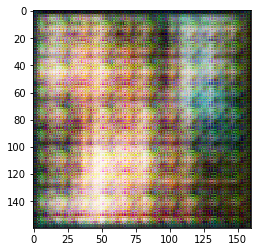

[0/2][750/2608]	Loss_D: 0.7589	Loss_G: 2.7326	D(x): 0.1996	D(G(z)): 0.7398 / 0.8593


In [0]:
train_gan_s(netD, netG, optimizerD, optimizerG, num_epochs=2)

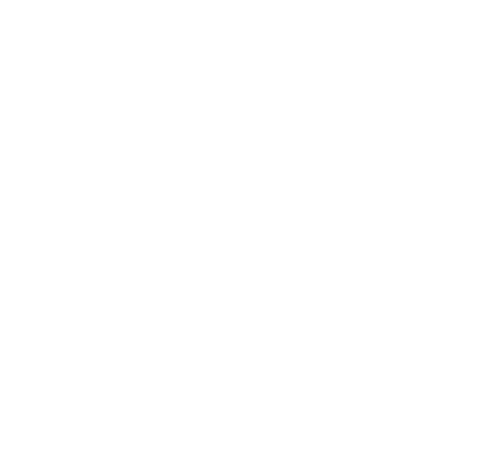

In [32]:
from IPython.display import HTML
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [0]:
g_save_path = "model_1g.pt"
d_save_path = "model_1d.pt"

torch.save(netG.state_dict(), g_save_path)
torch.save(netD.state_dict(), d_save_path)

In [0]:
train_gan3(netD, netG, train_loader, optimizerD, optimizerG, extra_gen_train=4, test_loader=None, print_metrics=250, plot_images=500,
              separate_batches=True, num_epochs=1, d_save_path="disc_model_1g.pt", g_save_path="gen_model_1g.pt")

RuntimeError: ignored

	Epoch 1 batch 500 gen total loss: 4.59612645816803 disc loss: 0.43238953826949 real probs: 0.12972707429435104 fake probs: 0.9588922122493386 disc acc: 0.9791666956152767
	Epoch 1 batch 1000 gen total loss: 4.567630971908569 disc loss: 0.4250217176328494 real probs: 0.13382666018300168 fake probs: 0.9616205701677818 disc acc: 0.9839239137203205
	Epoch 1 batch 1500 gen total loss: 4.223289457321167 disc loss: 0.4352003264994848 real probs: 0.13509456359993213 fake probs: 0.956685862528584 disc acc: 0.9837963255368686


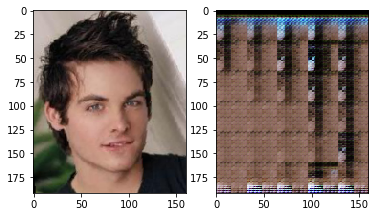

	Epoch 1 batch 2000 gen total loss: 4.835844204425812 disc loss: 0.4392704993249878 real probs: 0.13966556910484557 fake probs: 0.9587210665146509 disc acc: 0.9825562461545425
	Epoch 1 batch 2500 gen total loss: 4.57713997298479 disc loss: 0.45075713781414517 real probs: 0.14091408554061202 fake probs: 0.9546771499856262 disc acc: 0.9808917489306183
	Epoch 1 batch 3000 gen total loss: 4.962666882038117 disc loss: 0.44182865989619285 real probs: 0.13863109901982215 fake probs: 0.9573695745408061 disc acc: 0.983255997433547


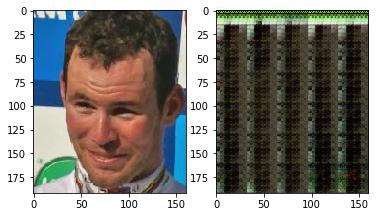

	Epoch 1 batch 3500 gen total loss: 5.079631068229675 disc loss: 0.4368983387675535 real probs: 0.1371287035847036 fake probs: 0.9600896856032635 disc acc: 0.9843394370465317
	Epoch 1 batch 4000 gen total loss: 4.974696236610413 disc loss: 0.43326043194532393 real probs: 0.13420226867496968 fake probs: 0.9627079489529133 disc acc: 0.9860000293850899
	Epoch 1 batch 4500 gen total loss: 5.115577011108399 disc loss: 0.4281617447733879 real probs: 0.13349710831046105 fake probs: 0.964093393355608 disc acc: 0.9872083627544344


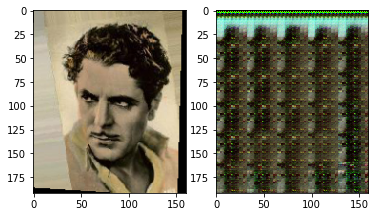

	Epoch 1 batch 5000 gen total loss: 5.086858333587647 disc loss: 0.42583886605501176 real probs: 0.13110302379727365 fake probs: 0.9654057026207447 disc acc: 0.988041696112603
	Epoch 1 batch 5500 gen total loss: 5.1550681977272035 disc loss: 0.42197006273269655 real probs: 0.1313674758821726 fake probs: 0.9690993029177188 disc acc: 0.9879166961088777
	Epoch 1 batch 6000 gen total loss: 4.55507232761383 disc loss: 0.42652374964952466 real probs: 0.13149440956115724 fake probs: 0.9684787879288197 disc acc: 0.9873333627581596


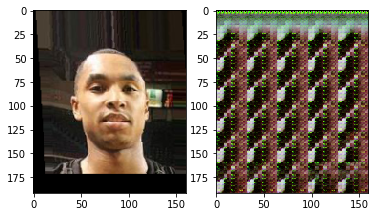

	Epoch 1 batch 6500 gen total loss: 4.694503410816193 disc loss: 0.41765576106309893 real probs: 0.12871969325840474 fake probs: 0.9721512229442596 disc acc: 0.9884166961237788


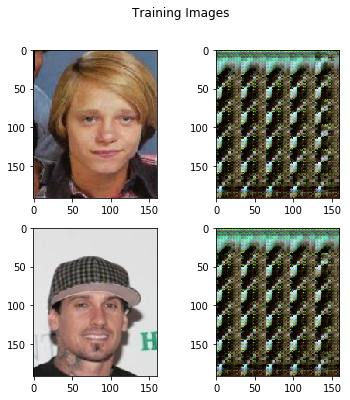

Epoch: 1 Gen Train Loss: 4.810378465941276 MSE Loss: 0.5 KLD Loss: 0.5 Mean GAN XE Loss: 0.5 Disc Train Loss: 0.42860527718108227 Test Loss: 0.5 Real probs: 0.13192067395395307 Fake probs: 0.9657731539517401 Avg Te Disc Acc: 0.5
Copying file://gen_model_1g.pt [Content-Type=application/octet-stream]...
\
Operation completed over 1 objects/36.5 MiB.                                     
Copying file://disc_model_1g.pt [Content-Type=application/octet-stream]...
\
Operation completed over 1 objects/44.6 MiB.                                     


In [0]:
train_gan(discriminator, generator, train_loader, d_optimizer, g_optimizer, extra_gen_train=8, test_loader=None, print_metrics=500, plot_images=1500,
              separate_batches=True, num_epochs=1, g_scheduler=g_scheduler, d_scheduler=d_scheduler, d_save_path="disc_model_1g.pt", g_save_path="gen_model_1g.pt")

	Epoch 2 batch 500 gen total loss: 5.242428734779358 disc loss: 0.4002966275720885 real probs: 0.13896920057860288 fake probs: 0.9636348738814845 disc acc: 0.9785353822464292
	Epoch 2 batch 1000 gen total loss: 5.400345949172974 disc loss: 0.38837580289691687 real probs: 0.12762863317038864 fake probs: 0.9722975566983223 disc acc: 0.9879557583772112
	Epoch 2 batch 1500 gen total loss: 5.480793608665467 disc loss: 0.3873648009802166 real probs: 0.12156820030588852 fake probs: 0.9753243898090563 disc acc: 0.9907895030551835


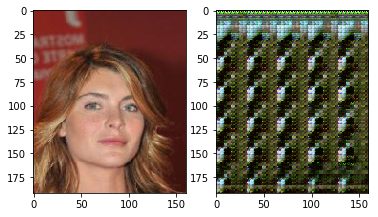

	Epoch 2 batch 2000 gen total loss: 5.285769394397736 disc loss: 0.4009920935931168 real probs: 0.11929992844504635 fake probs: 0.9671146475423978 disc acc: 0.9865485857145524
	Epoch 2 batch 2500 gen total loss: 4.661337999820709 disc loss: 0.40721847381018383 real probs: 0.1235294279324103 fake probs: 0.9643850473663474 disc acc: 0.9872099449386513
	Epoch 2 batch 3000 gen total loss: 4.838339870452881 disc loss: 0.40830818275925973 real probs: 0.127863995139561 fake probs: 0.9653546485320601 disc acc: 0.9883157260242909


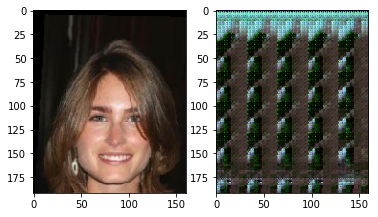

	Epoch 2 batch 3500 gen total loss: 4.6727150874137875 disc loss: 0.41180308176712555 real probs: 0.13170231289484285 fake probs: 0.9646695099093697 disc acc: 0.988825786977329
	Epoch 2 batch 4000 gen total loss: 5.240764530181885 disc loss: 0.40964814902298036 real probs: 0.13225187668724667 fake probs: 0.9657030502955118 disc acc: 0.9898313786464906
	Epoch 2 batch 4500 gen total loss: 5.142299464225769 disc loss: 0.410153288723302 real probs: 0.1320065215967148 fake probs: 0.9666205004331501 disc acc: 0.9902090989513974


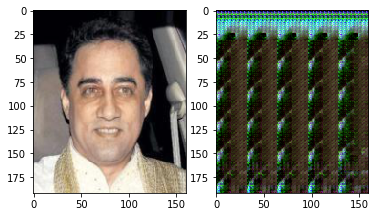

Epoch: 2 Gen Train Loss: 5.1060116337433135 MSE Loss: 0.5 Mean GAN XE Loss: 0.5 Disc Train Loss: 0.4102012582228217 Avg Tr Disc Acc: 0.9902435740600275
Interrupting... Saving model...


Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

Copying file://gen_model_1g.pt [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/36.5 MiB.                                     
Copying file://disc_model_1g.pt [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/44.6 MiB.                                     


In [0]:
train_gan(discriminator, generator, train_loader, d_optimizer, g_optimizer, extra_gen_train=16, test_loader=None, print_metrics=500, plot_images=1500,
              separate_batches=True, num_epochs=1, g_scheduler=g_scheduler, d_scheduler=d_scheduler, d_save_path="disc_model_1g.pt", g_save_path="gen_model_1g.pt")

	Epoch 2 batch 500 gen total loss: 1.028687178373337 disc loss: 0.2289942353963852 real probs: 0.13580486485186746 fake probs: 0.9690576125593746 disc acc: 0.9620098317151561
	Epoch 2 batch 1000 gen total loss: 1.079519741177559 disc loss: 0.21415850926529278 real probs: 0.11388582555633603 fake probs: 0.9836418285514369 disc acc: 0.9804293216968124


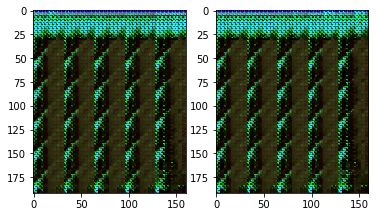

	Epoch 2 batch 1500 gen total loss: 1.0732300847768783 disc loss: 0.20861794085552296 real probs: 0.1088649071753025 fake probs: 0.9880480741461118 disc acc: 0.9843750290262202
	Epoch 2 batch 2000 gen total loss: 1.0077492195367812 disc loss: 0.20582828810438514 real probs: 0.10644158779177815 fake probs: 0.9904991574585438 disc acc: 0.9869791958481073


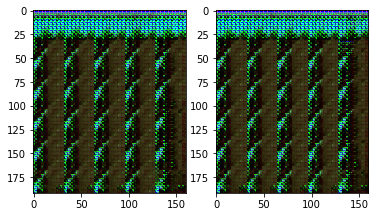

	Epoch 2 batch 2500 gen total loss: 1.0080457166433334 disc loss: 0.2064448729157448 real probs: 0.10498727764934301 fake probs: 0.9917100533843041 disc acc: 0.9877604459179565
	Epoch 2 batch 3000 gen total loss: 0.9209205815792084 disc loss: 0.20542814166922319 real probs: 0.10442138910293579 fake probs: 0.9927197017167744 disc acc: 0.9892544152901361


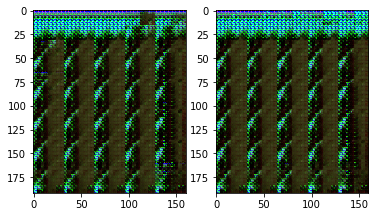

	Epoch 2 batch 3500 gen total loss: 0.948068177819252 disc loss: 0.20311904248890575 real probs: 0.10207081854611903 fake probs: 0.9934348179413391 disc acc: 0.9904279573107356
	Epoch 2 batch 4000 gen total loss: 0.9933797563314438 disc loss: 0.20380478381641268 real probs: 0.10292307774382313 fake probs: 0.9937210463163421 disc acc: 0.9903215517062606


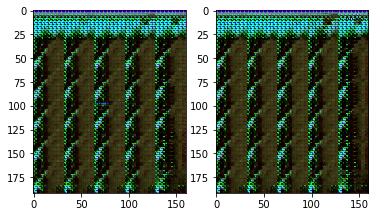

	Epoch 2 batch 4500 gen total loss: 0.9351299613714218 disc loss: 0.20520565008193675 real probs: 0.10354514404291838 fake probs: 0.9937362154604683 disc acc: 0.9904636444366524


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send

Epoch: 2 Gen Train Loss: 0.9990919990568247 MSE Loss: 0.5 Mean GAN XE Loss: nan Disc Train Loss: 0.20492100333304783 Avg Tr Disc Acc: 0.990679853987929
Interrupting... Saving model...
Copying file://gen_model_1g.pt [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/36.5 MiB.                                     
Copying file://disc_model_1g.pt [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/44.6 MiB.                                     


In [0]:
train_gan3(discriminator, generator, train_loader, d_optimizer, g_optimizer, extra_gen_train=32, test_loader=None, print_metrics=500, plot_images=1000,
              separate_batches=True, num_epochs=1, g_scheduler=g_scheduler, d_scheduler=d_scheduler, d_save_path="disc_model_1g.pt", g_save_path="gen_model_1g.pt")

	Epoch 2 batch 500 gen total loss: 1.5708378862142562 disc loss: 1.5330325119635637 real probs: 0.6092378286754384 fake probs: 0.6752902619978961 disc acc: 0.589460801004487
	Epoch 2 batch 1000 gen total loss: 1.57932462733984 disc loss: 1.3986504673957825 real probs: 0.5476387558561383 fake probs: 0.6967308376774644 disc acc: 0.6571969888314153
	Epoch 2 batch 1500 gen total loss: 2.1046674188375474 disc loss: 1.3640385220448177 real probs: 0.5263049670805534 fake probs: 0.7108594514429569 disc acc: 0.6896701591322199


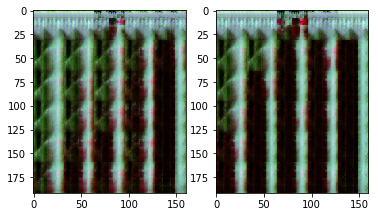

	Epoch 2 batch 2000 gen total loss: 2.5539202798604963 disc loss: 1.3141070939600468 real probs: 0.5049810986965895 fake probs: 0.7210182095877826 disc acc: 0.7044271040940657
	Epoch 2 batch 2500 gen total loss: 1.9276633303165436 disc loss: 1.2618880674242974 real probs: 0.47556964196264745 fake probs: 0.7176715947687626 disc acc: 0.718489604559727
	Epoch 2 batch 3000 gen total loss: 1.4595535710453986 disc loss: 1.2499577785793103 real probs: 0.462651779149708 fake probs: 0.7149765482074336 disc acc: 0.727631600475625


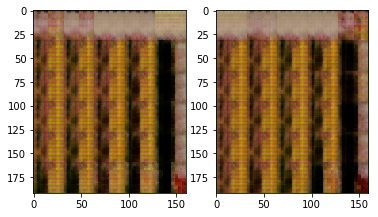

	Epoch 2 batch 3500 gen total loss: 1.4826479227542877 disc loss: 1.282774321667783 real probs: 0.4613376077230986 fake probs: 0.701746472904274 disc acc: 0.7158408620403157
	Epoch 2 batch 4000 gen total loss: 1.1758431217968464 disc loss: 1.3123675894549514 real probs: 0.4578662527593102 fake probs: 0.6852924614910065 disc acc: 0.7075131443277822
	Epoch 2 batch 4500 gen total loss: 1.228940087646246 disc loss: 1.356353978036155 real probs: 0.46623424860373347 fake probs: 0.6718271647540617 disc acc: 0.6895540110557012


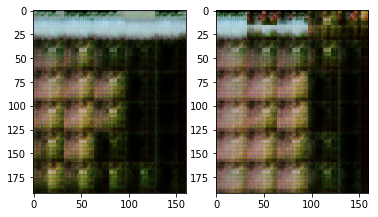

	Epoch 2 batch 5000 gen total loss: 0.7131468153595925 disc loss: 1.4069487263884726 real probs: 0.4670625603463076 fake probs: 0.6469372763663908 disc acc: 0.6660074037205004
	Epoch 2 batch 5500 gen total loss: 1.068593226134777 disc loss: 1.4306814756696624 real probs: 0.4723670078667602 fake probs: 0.6387657107989912 disc acc: 0.6541426012970809
	Epoch 2 batch 6000 gen total loss: 1.4480959095954895 disc loss: 1.4285329148252175 real probs: 0.47761416632347004 fake probs: 0.6439501890745113 disc acc: 0.6555335291577552


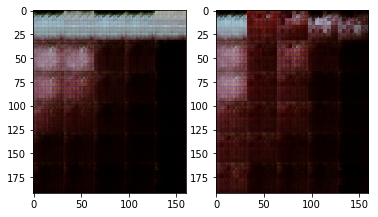

	Epoch 2 batch 6500 gen total loss: 1.134472920179367 disc loss: 1.4399780067001902 real probs: 0.4783778505354393 fake probs: 0.6374572746637391 disc acc: 0.6502032713373986


In [0]:
train_gan(discriminator, generator, train_loader, d_optimizer, g_optimizer, extra_gen_train=32, test_loader=None, print_metrics=500, plot_images=1500,
              separate_batches=True, num_epochs=1, g_scheduler=g_scheduler, d_scheduler=d_scheduler, d_save_path="disc_model_1g.pt", g_save_path="gen_model_1g.pt")

In [0]:
train_gan(discriminator, generator, train_loader, d_optimizer, g_optimizer, extra_gen_train=8, test_loader=None, print_metrics=500, plot_images=1500,
              separate_batches=True, num_epochs=1, g_scheduler=g_scheduler, d_scheduler=d_scheduler, d_save_path="disc_model_1g.pt", g_save_path="gen_model_1g.pt")

In [0]:
train_gan(discriminator, generator, train_loader, d_optimizer, g_optimizer, extra_gen_train=16, test_loader=None, print_metrics=500, plot_images=1500,
              separate_batches=True, num_epochs=1, g_scheduler=g_scheduler, d_scheduler=d_scheduler, d_save_path="disc_model_1g.pt", g_save_path="gen_model_1g.pt")

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


Epoch: 0 Gen Train Loss: 4.701740119192335 MSE Loss: 0.5 Mean GAN XE Loss: nan Disc Train Loss: 0.22899398456017175 Avg Tr Disc Acc: 0.8333333532015482
Interrupting... Saving model...
Copying file://gen_model_1g.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

|
Operation completed over 1 objects/246.5 MiB.                   

Accuracy: tensor(0.5833, device='cuda:0')
0.7824792861938477


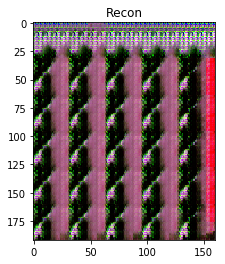

0.5986606478691101


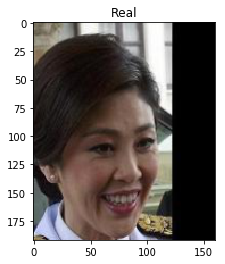

In [0]:
# check that the discriminator is working properly
with torch.no_grad():
    for (inputs, _) in train_loader:
        generator.eval()
        batch_size = inputs.shape[0]
        
        noise = torch.randn(batch_size, latent_dim, 1, 1).cuda()
        recon = generator(noise)
        
        # feed the original images to the discriminator
        real_probs = torch.sigmoid(discriminator(inputs.cuda()))
        fake_probs = torch.sigmoid(discriminator(recon))
        
        probs = torch.cat((real_probs, fake_probs), 0).float()
        labels = torch.cat((torch.zeros(batch_size), torch.ones(batch_size)), 0).cuda()
        
        print("Accuracy:", torch.mean((torch.round(probs) == labels).float()))
        print(fake_probs[0].item())
        plt.imshow(recon[0].cpu().permute(1,2,0))
        plt.title("Recon")
        plt.show()
        
        print(real_probs[0].item())
        plt.imshow(inputs[0].cpu().permute(1,2,0))
        plt.title("Real")
        plt.show()
        
        break

In [0]:
for (image, label) in zip(disc_batch, d_preds):
    plt.imshow(image.detach().cpu().permute(1, 2, 0))
    plt.title(str(label))
    plt.show()

In [0]:
inputs = torch.autograd.Variable(recon.clone().cuda(), requires_grad=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


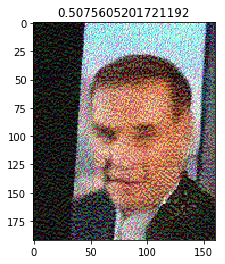

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


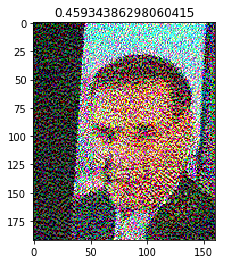

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


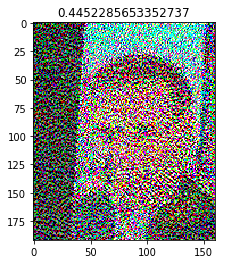

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


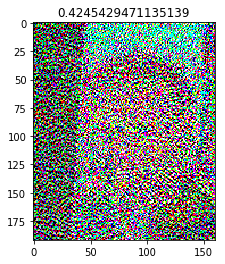

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


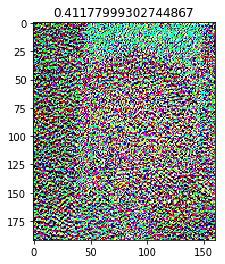

KeyboardInterrupt: ignored

In [0]:
# create a random tensor of the proper size
# inputs = torch.autograd.Variable(torch.randn(2, 3, 192, 160).cuda(), requires_grad=True)

# create an optimizer for our images
r_opt = optim.Adam([inputs], lr=0.001)

# loss function is we want the images to be predicted as real
def rev_loss(d_faked):
    labels = torch.ones(d_faked.shape[0]).cuda()
#     labels = torch.zeros(d_faked.shape[0]).cuda()
    d_loss = nn.functional.binary_cross_entropy_with_logits(d_faked, labels, reduction="mean")
    
    return d_loss

# discriminator.eval()  
  
for j in range(10):  
  losses = []
  for i in range(200):
      logits = discriminator(inputs)
      loss = rev_loss(logits)
#       print(loss.item())
      loss.backward()
      r_opt.step()
      losses.append(loss.item())
      
  plt.imshow(inputs[0].detach().cpu().permute(1, 2, 0) )
  plt.title(str(np.mean(losses)))
  plt.show()

In [0]:
## CHECK MEAN AND VARIANCE OF CODES
with torch.no_grad():
    for (inputs, _) in test_loader:
      generator.encoder.eval()
      generator.decoder.eval()
      # encode the images and reconstruct them
      codes, logvar = generator.encoder(inputs.cuda())
      print("Mean:", torch.mean(codes))
      print("Std:", codes.std())
      recon = generator.decoder(codes)
      d_faked = discriminator(recon)
      print("Faked Logits Mean:", d_faked.mean())
      vae_loss(inputs.cuda(), recon, codes, logvar=logvar, d_faked = d_faked, debug = True)
      break

Mean: tensor(-0.0188, device='cuda:0')
Std: tensor(3.1603, device='cuda:0')
Faked Logits Mean: tensor(0.0726, device='cuda:0')
MSE Loss Raw: tensor(0.0024, device='cuda:0')
MSE Loss Weighted: tensor(0.4753, device='cuda:0')
KLD Loss Raw: tensor([0.])
KLD Loss Weighted: tensor([0.])
Disc Loss Raw: tensor(0.7382, device='cuda:0')
Disc Loss Weighted: tensor(0.1476, device='cuda:0')
Total Loss (weighted): tensor(0.6230, device='cuda:0')


#### Additional Training on Personal Images

In [0]:
!mkdir data/Train
!cp -r data/images/Training_Pictures data/Train/Images

In [0]:
train_dataset2 = torchvision.datasets.ImageFolder(
        root="data/Train",
        transform=transform
    )

train_loader2 = torch.utils.data.DataLoader(
    train_dataset2,
    batch_size=BATCH_SIZE,
    num_workers=2,
    shuffle=True
)

In [0]:
# resume training the discriminator as well
train_gan(discriminator, generator, train_loader2, d_optimizer, g_optimizer, print_metrics=1000, plot_images=2000, num_epochs=51, extra_gen_train=1024, test_loader=None, separate_batches=True, g_scheduler=g_scheduler, d_scheduler=d_scheduler, d_save_path="disc_model_3.pt", g_save_path="gen_model_3.pt")

NameError: ignored

In [0]:
noise = np.random.normal(loc=0.3, scale=7.5, size=4096).reshape((1,4096,1,1))
image = model.decoder(torch.from_numpy(noise).cuda().float())
plt.imshow(image[0].cpu().detach().permute(1,2,0))
plt.show()

#### Additional Training on Specific Images

In [0]:
# # download and unzip the data
# url = "https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/GWB_64x64.zip"
# if not os.path.exists("gwb_images.zip"):
#   wget.download(url, 'gwb_images.zip')

#   zip_ref = zipfile.ZipFile('gwb_images.zip', 'r')
#   zip_ref.extractall('data/gwb')
#   zip_ref.close()

In [0]:
# use the existing encoder to create a GWBush decoder
from torch import optim
import numpy as np

  ## YOUR CODE HERE ##
encoder = model.encoder
gwb_decoder = Decoder(2048)
gwb_model = SingleModel(encoder, gwb_decoder)
gwb_params = gwb_model.decoder.parameters()

# run on GPU
use_cuda = True

if use_cuda and torch.cuda.is_available():
    encoder.cuda()
    gwb_decoder.cuda()
    gwb_model.cuda()
    
optimizer = optim.Adam(gwb_params, lr=0.002)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)    

In [0]:
# gwb dataset
BATCH_SIZE = 64
data_path = "data/gwb"

transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(p=0.5), 
      torchvision.transforms.RandomChoice([
        torchvision.transforms.RandomAffine(degrees=7, translate=(0.05,0.05), scale=(0.9,1.1), shear=3, resample=False, fillcolor=0),
        torchvision.transforms.RandomResizedCrop((192,160), scale=(0.90, 1.1)),
      ]),
    torchvision.transforms.ToTensor(),
    ])

gwb_train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transform
    )

gwb_train_loader2 = torch.utils.data.DataLoader(
    gwb_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [0]:
for (images, _) in gwb_train_loader2:
  plt.imshow(images[0].permute(1,2,0))
  break

In [0]:
train(gwb_model, gwb_train_loader2, optimizer, print_metrics=0, num_epochs=200, display_images=20, scheduler=scheduler, save_path="./gwb_model.pt")